# Задача 5. Обучение без учителя

* **Дедлайн**: 14.03.2025, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- Найти данные с количеством признаков хотя бы 50, на которых можно решить задачу кластеризации.
- Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- Самостоятельно реализуйте один из алгоритмов кластеризации, например **K-means**.
- Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из **sklearn** (**KMeans**, **Affinity Propogation**, **DBSCAN** и тд).
- При обучении использовать **подбор гиперпараметров**.
- Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.
- (**+3 балла**) Также снизить размерность данных с помощью метода главных компонент **PCA** и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
- (**+2 балла**) Визуализировать данные снижением размерности до 2 или 3 с помощью **PCA** и **t-SNE**. В случае проблем с производительностью **t-SNE**, можно сначала до какой то степени снизить размерность с помощью **PCA**, а затем запустить **t-SNE**.


## Импорты

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import kagglehub
import optuna

from datetime import datetime
from sklearn.base import BaseEstimator
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score, rand_score, silhouette_score, calinski_harabasz_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from optuna.samplers import BruteForceSampler
from sklearn.utils import validation

Необходимые зависимости указаны в `req.txt`

## 1) EDA [Датасет](https://www.kaggle.com/datasets/zakariakhodri3/french-cities-2005)

### French cities

The dataset covers a wide range of socio-economic, environmental (Nature), and health-related indicators of 100 cities in France from the year 2005. the variables/features are partitioned like this :

Economics : Chomage, ChomageJeunes, ChomageLong, EvoluEmploiCree, Activite, EmploiFeminin,
EmploiCommune, DefaillEntreprise, SalaireAnnuel, ImpotRevenu, ImpotFortune, Imposables,
MetreCarreAncien, TaxeHabitation, FoncierBati, MetreCubeEau, EvolDemographique, Vieillissement,
AttiranceGlobale, AttiranceActifs, Proprietaires, LogtSup4pieces, LogtInsalubre, LogtVacant,
LogtConstruction

Risk Factors : Criminalite, EvolutionCrimes, SecuriteRoutiere, Inondations, TerrainsPollues, UsinesRisques,
MortaliteInfantile, MortaliteCancerPoumon, MortaliteAlcool, DecesInfarctus, TauxSuicide,
MortaliteGlobale, TailleClassesPrimaires, Retard6eme, Retard3eme, RetardTerminale

Nature : Mer, Ski, Soleil, Pluie, Temperature, MarcheAPied

Culture : Musees, Cinema, MonumHistoriques, PretLivres, RestaurDistingues, Presse, Etudiants.

## 2) EDA

In [220]:
path = kagglehub.dataset_download("zakariakhodri3/french-cities-2005")
print(path)
df = pd.read_csv(filepath_or_buffer=path + "/French_cities_2005.csv", sep='\t')
df.head()

/home/pasha/.cache/kagglehub/datasets/zakariakhodri3/french-cities-2005/versions/2


,Ville,Chomage,ChomageJeunes,ChomageLong,EvoluEmploiCree,Activite,EmploiFeminin,EmploiCommune,DefaillEntreprise,SalaireAnnuel,...,RestaurDistingues,Presse,Etudiants,ImpotRevenu,ImpotFortune,Imposables,EvolDemographique,Vieillissement,AttiranceGlobale,AttiranceActifs
0,Agen,0.181,0.161,0.58,0.05,0.44,0.53,0.56,0.18,17210,...,0.0,28.6,0.06,1067,0.005,46,-0.013,0.56,0.38,0.47
1,AixEnProvence,0.166,0.133,0.55,0.10,0.43,0.47,0.57,0.13,22232,...,1.0,19.9,0.31,2121,0.015,57,0.084,0.37,0.37,0.39
2,Ajaccio,0.166,0.181,0.52,0.02,0.43,0.46,0.77,0.14,17882,...,1.0,24.4,0.01,1207,0.004,47,-0.103,0.37,0.19,0.21
3,Albi,0.144,0.151,0.54,0.05,0.42,0.51,0.67,0.09,17923,...,0.0,22.1,0.07,1245,0.004,51,-0.007,0.59,0.31,0.35
4,Amiens,0.200,0.165,0.61,0.05,0.44,0.46,0.64,0.17,18037,...,0.0,14.7,0.18,1208,0.006,47,0.028,0.24,0.26,0.28


Общая информация.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 55 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Ville                   100 non-null    object 
 1   Chomage                 100 non-null    float64
 2   ChomageJeunes           100 non-null    float64
 3   ChomageLong             100 non-null    float64
 4   EvoluEmploiCree         100 non-null    float64
 5   Activite                100 non-null    float64
 6   EmploiFeminin           100 non-null    float64
 7   EmploiCommune           100 non-null    float64
 8   DefaillEntreprise       100 non-null    float64
 9   SalaireAnnuel           100 non-null    int64  
 10  Criminalite             100 non-null    float64
 11  EvolutionCrimes         100 non-null    float64
 12  SecuriteRoutiere        100 non-null    float64
 13  Inondations             100 non-null    int64  
 14  TerrainsPollues         100 non-null    int

In [222]:
df.isnull().sum()

Ville                     0
Chomage                   0
ChomageJeunes             0
ChomageLong               0
EvoluEmploiCree           0
Activite                  0
EmploiFeminin             0
EmploiCommune             0
DefaillEntreprise         0
SalaireAnnuel             0
Criminalite               0
EvolutionCrimes           0
SecuriteRoutiere          0
Inondations               0
TerrainsPollues           0
UsinesRisques             0
MortaliteInfantile        0
MortaliteCancerPoumon     0
MortaliteAlcool           0
DecesInfarctus            0
TauxSuicide               0
MortaliteGlobale          0
TailleClassesPrimaires    0
Retard6eme                0
Retard3eme                0
RetardTerminale           0
MetreCarreAncien          0
TaxeHabitation            0
FoncierBati               0
MetreCubeEau              0
Proprietaires             0
LogtSup4pieces            0
LogtInsalubre             0
LogtVacant                0
LogtConstruction          0
Mer                 

У нас нету пропущенных значений.


In [223]:
len(df.head().columns)

55

In [224]:
labels = df["Ville"]
print(labels.unique(), len(labels.unique()))

['Agen' 'AixEnProvence' 'Ajaccio' 'Albi' 'Amiens' 'Angers' 'Angouleme'
 'Annecy' 'Antibes' 'Arles' 'Auxerre' 'Avignon' 'Bastia' 'Bayonne'
 'Beauvais' 'Belfort' 'Besancon' 'Beziers' 'Blois' 'Bordeaux'
 'BoulogneBillancourt' 'BourgEnBresse' 'Bourges' 'Brest'
 'BriveLaGaillarde' 'Caen' 'Calais' 'Cannes' 'Carcassonne' 'Castres'
 'ChalonSurSaone' 'Chambery' 'CharlevilleMezieres' 'Chartres' 'Cholet'
 'ClermontFerrand' 'Colmar' 'Compiegne' 'CorbeilEssonnes' 'Creteil'
 'Dijon' 'Dunkerque' 'Epinal' 'Evry' 'Gap' 'Grenoble' 'La Rochelle'
 'La RocheSurYon' 'Laval' 'LeHavre' 'LeMans' 'Lille' 'Limoges' 'Lyon'
 'Marseille' 'Melun' 'Metz' 'Montauban' 'Montlucon' 'Montpellier'
 'Mulhouse' 'Nancy' 'Nantes' 'NeuillySurSeine' 'Nevers' 'Nice' 'Nimes'
 'Niort' 'Orleans' 'Paris' 'Pau' 'Perigueux' 'Perpignan' 'Poitiers'
 'Quimper' 'Reims' 'Rennes' 'Rouen' 'RueilMalmaison' 'SaintBrieuc'
 'SaintDenis' 'SaintEtienne' 'SaintGermainEnLaye' 'SaintMalo'
 'SaintNazaire' 'SaintQuentin' 'Sarcelles' 'Sete' 'Strasbourg' 

Данный датасет содержит информацию о 100 горадах во Франции, что для домашнего задание будет очень большим количеством. Более того, многие из этих городов являются частями других, например, Парижа.

Используя различные эвристики, попытаемся определить оптимальное чилсо кластеров для данного датасета.

#### Метод локтя

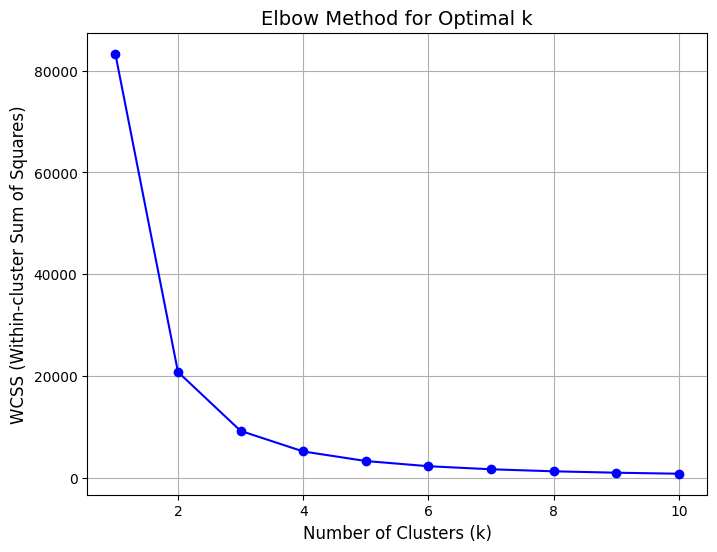

In [225]:
le = LabelEncoder()
df['Ville_encoded'] = le.fit_transform(df['Ville'])

X = df[['Ville_encoded']].values

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', color='b')
plt.title('Elbow Method for Optimal k', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('WCSS (Within-cluster Sum of Squares)', fontsize=12)
plt.grid(True)
plt.show()

Из графика видно что, согласно данной эвристике, оптимальным числом кластеров может быть 2, 3, 4, 5, 6 и, как вариант 7, 8.

#### Davies–Bouldin index

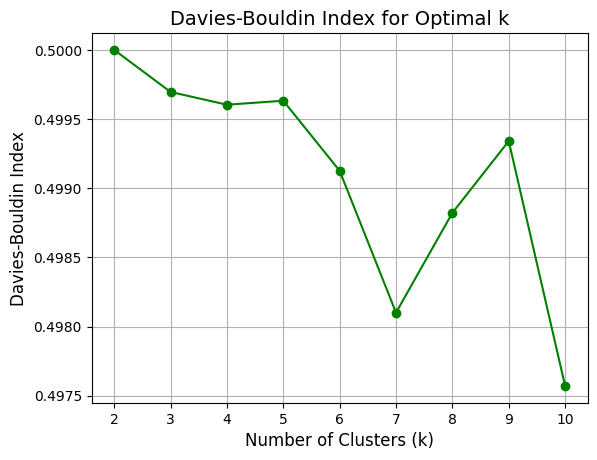

In [226]:
dbi_scores = []
for k in range(2, 11):  
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    dbi_scores.append(davies_bouldin_score(X, kmeans.labels_))

plt.plot(range(2, 11), dbi_scores, marker='o', color='g')
plt.title('Davies-Bouldin Index for Optimal k', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Davies-Bouldin Index', fontsize=12)
plt.grid(True)
plt.show()

Данный индекс показывает, что оптимальным числом кластеров может выступать 6, 7, 8 и 10.

Возьмем далее "7" за оптимальное числа кластеров.

## 2) t-sne и PSA

/home/pasha/task6/task5-unsupervised-learning/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/pasha/task6/task5-unsupervised-learning/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


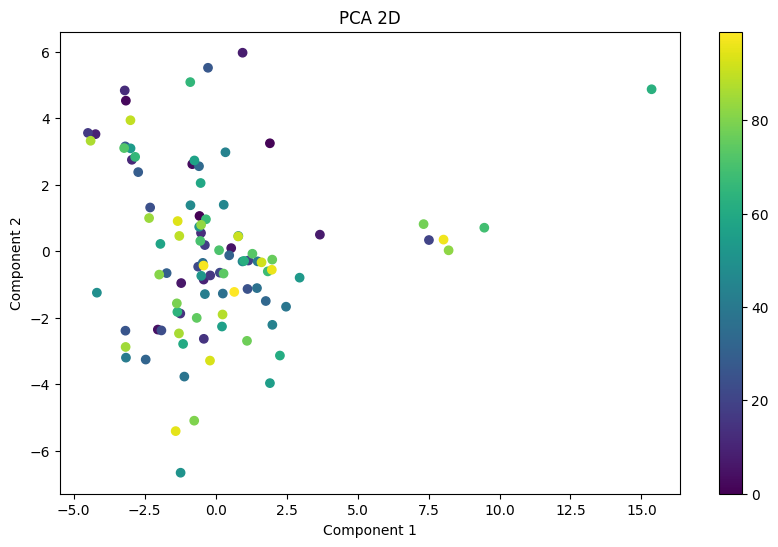

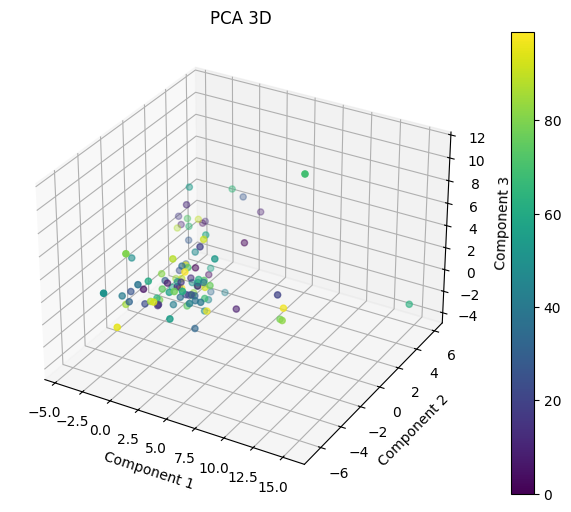

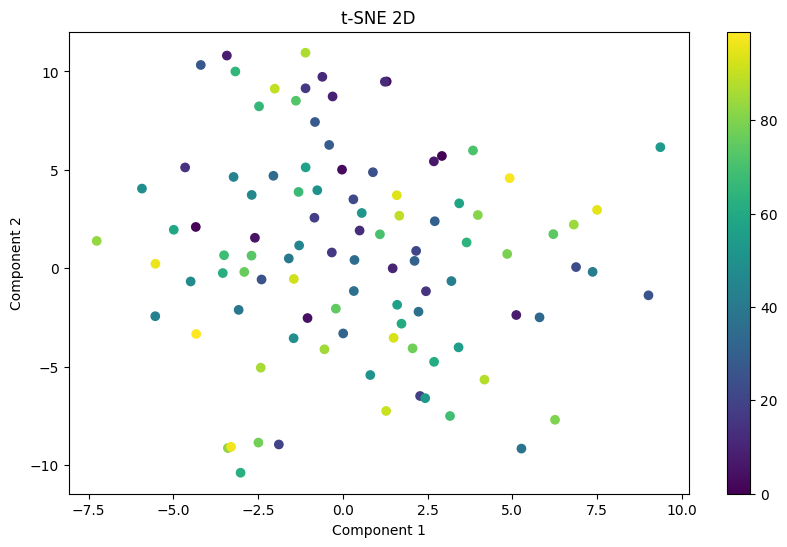

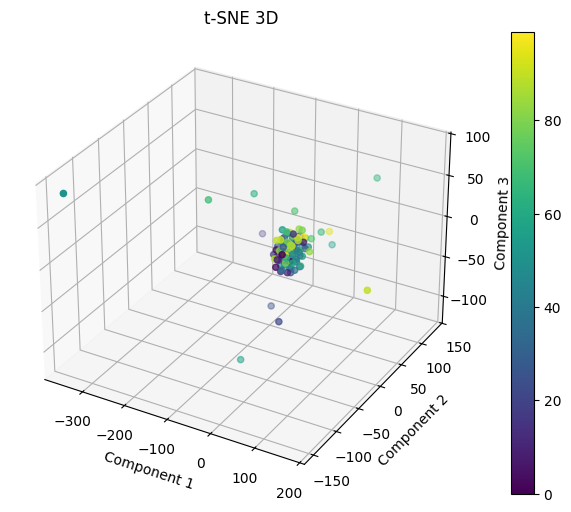

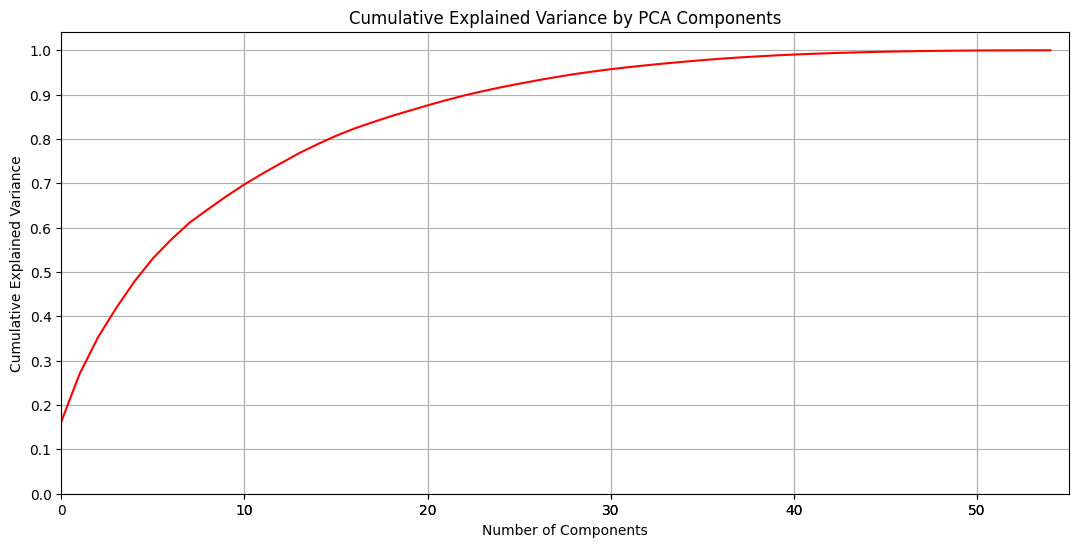

In [228]:
labels = df["Ville"]
features = df.drop(columns=["Ville"])

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# PCA для 2D и 3D
pca_2d = PCA(n_components=2)
pca_result_2d = pca_2d.fit_transform(features_scaled)

pca_3d = PCA(n_components=3)
pca_result_3d = pca_3d.fit_transform(features_scaled)

# t-SNE для 2D и 3D
tsne_2d = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_result_2d = tsne_2d.fit_transform(features_scaled)

tsne_3d = TSNE(n_components=3, perplexity=30, n_iter=300, random_state=42)
tsne_result_3d = tsne_3d.fit_transform(features_scaled)

# Визуализация PCA и t-SNE
def plot_2d(result, title, labels):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(result[:, 0], result[:, 1], c=labels.astype('category').cat.codes, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

def plot_3d(result, title, labels):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(result[:, 0], result[:, 1], result[:, 2], c=labels.astype('category').cat.codes, cmap='viridis')
    plt.colorbar(scatter)
    ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.show()

# Визуализация PCA
plot_2d(pca_result_2d, 'PCA 2D', labels)
plot_3d(pca_result_3d, 'PCA 3D', labels)

# Визуализация t-SNE
plot_2d(tsne_result_2d, 't-SNE 2D', labels)
plot_3d(tsne_result_3d, 't-SNE 3D', labels)

pca_full = PCA()
pca_full.fit(features_scaled)

plt.figure(figsize=(13, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), color='red')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(list(plt.xticks()[0]) + [10, 20, 30, 40, 50])  
plt.xlim(0, len(pca_full.explained_variance_ratio_))
plt.grid(True)
plt.title("Cumulative Explained Variance by PCA Components")
plt.show()

График показывает следующее: 10 признаков позволяет описать 70% дисперсии, 20 примерно 90%, 30 примерно 95-96%. При этом примерно с 40-ка признаков мы не будем получать существенное количество информации. 

In [229]:
labels_free = df.drop(columns=["Ville"])

### Имплементация KMeans

In [230]:
class CustomKMeans(BaseEstimator):
    def __init__(self, n_clusters=7, max_iter=300, random_state = 0, eps=0.01):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.cluster_centers_ = None
        self.eps = eps
        self.random_state = random_state
    
    def fit(self, data, targets=None):
        data = validation.check_array(data)
        np.random.seed(self.random_state)
        self.cluster_centers_ = data[np.random.choice(data.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            cluster_assignments = self.predict(data)
            updated_centers = np.array([
                data[cluster_assignments == cluster].mean(axis=0)
                for cluster in range(self.n_clusters)
            ])
            if np.linalg.norm(updated_centers - self.cluster_centers_) < self.eps:
                break
            self.cluster_centers_ = updated_centers

        return self
    
    def predict(self, input_data):
        input_data = validation.check_array(input_data)
        results = np.zeros(input_data.shape[0], dtype=int)
        for idx, sample in enumerate(input_data):
            distances = np.sqrt(np.sum((sample - self.cluster_centers_) ** 2, axis=1))
            results[idx] = np.argmin(distances)
        return results

### Подбор параметров

In [231]:
enumrated_y = {key : v for v, key in enumerate(labels.unique())}
numbers = [enumrated_y[label] for label in labels]

def run_test(objective):
    study = optuna.create_study(direction="maximize", sampler=BruteForceSampler())
    study.optimize(objective, n_trials=20)
    return study.best_params

def create_objective(model_class, fixed_params, param_suggestions):
    def objective(trial):
        params = {**fixed_params, **{k: v(trial, k) for k, v in param_suggestions.items()}}
        model = model_class(**params)
        cv = KFold(n_splits=5, shuffle=True, random_state=params["random_state"])
        cross_val = cross_val_score(model, X, numbers, scoring="rand_score", cv=cv, n_jobs=-1)
        return cross_val.mean()
    return objective

param_suggestions = {
    "customKMeans": {"max_iter": lambda t, k: t.suggest_categorical(k, [100 * i for i in range(1, 10)])},
    "kmeans": {
        "max_iter": lambda t, k: t.suggest_categorical(k, [100 * i  for i in range(1, 10)]),
        "init": lambda t, k: t.suggest_categorical(k, ['random', 'k-means++'])
    },
    "affinity": {
        "damping": lambda t, k: t.suggest_float(k, 0.5, 0.99, step=0.01),
        "max_iter": lambda t, k: t.suggest_categorical(k, [100 * i  for i in range(1, 10)]),
        "convergence_iter": lambda t, k: t.suggest_int(k, 10, 100)
    }
}

fixed_params = {
    "customKMeans": {"n_clusters": 7, "random_state": 5, "eps": 0.01},
    "kmeans": {"n_clusters": 7, "random_state": 5, "tol": 0.01},
    "affinity": {"random_state": 5}
}

objectives = {
    "customKMeans": create_objective(CustomKMeans, fixed_params["customKMeans"], param_suggestions["customKMeans"]),
    "kmeans": create_objective(KMeans, fixed_params["kmeans"], param_suggestions["kmeans"]),
    "affinity": create_objective(AffinityPropagation, fixed_params["affinity"], param_suggestions["affinity"])
}

best_params = {name: run_test(obj) for name, obj in objectives.items()}

best_customKMeans_params = best_params["customKMeans"]
best_kmeans_params = best_params["kmeans"]
best_affinity_params = best_params["affinity"]

print("\n ************************* ")
print("Best parameters for CustomKMeans:", best_customKMeans_params)
print("Best parameters for KMeans:", best_kmeans_params)
print("Best parameters for Affinity Propagation:", best_affinity_params)
print(" ************************* \n")

/tmp/ipykernel_6529/1490632513.py:5: ExperimentalWarning: BruteForceSampler is experimental (supported from v3.1.0). The interface can change in the future.
  study = optuna.create_study(direction="maximize", sampler=BruteForceSampler())
[I 2025-03-05 15:54:03,807] A new study created in memory with name: no-name-a302c713-d350-41f8-b133-c39135811eba
[I 2025-03-05 15:54:04,735] Trial 0 finished with value: 0.8557894736842104 and parameters: {'max_iter': 200}. Best is trial 0 with value: 0.8557894736842104.
[I 2025-03-05 15:54:05,265] Trial 1 finished with value: 0.8557894736842104 and parameters: {'max_iter': 500}. Best is trial 0 with value: 0.8557894736842104.
[I 2025-03-05 15:54:05,810] Trial 2 finished with value: 0.8557894736842104 and parameters: {'max_iter': 900}. Best is trial 0 with value: 0.8557894736842104.
[I 2025-03-05 15:54:06,345] Trial 3 finished with value: 0.8557894736842104 and parameters: {'max_iter': 100}. Best is trial 0 with value: 0.8557894736842104.
[I 2025-03-0


 ************************* 
Best parameters for CustomKMeans: {'max_iter': 200}
Best parameters for KMeans: {'max_iter': 200, 'init': 'k-means++'}
Best parameters for Affinity Propagation: {'damping': 0.75, 'max_iter': 300, 'convergence_iter': 47}
 ************************* 



### Сравенение моделей

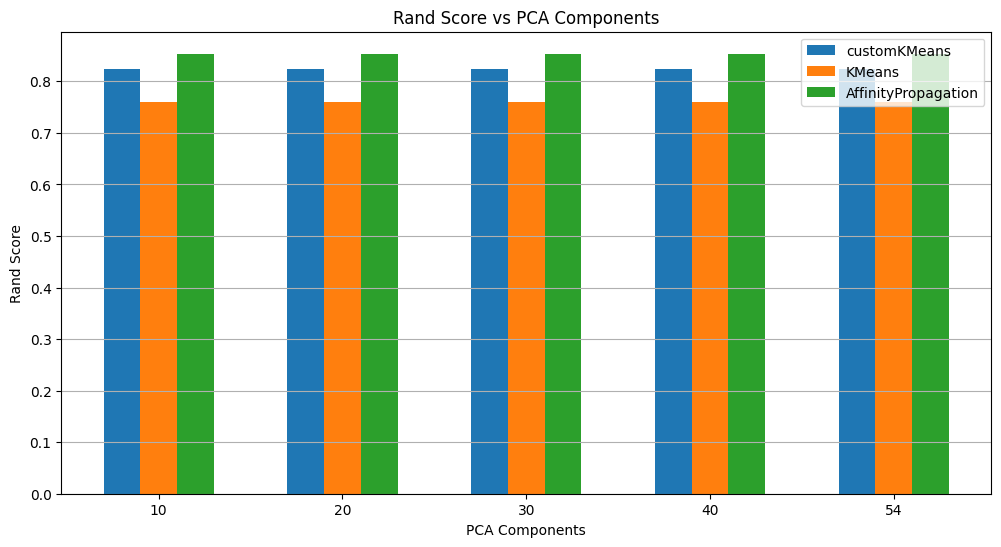

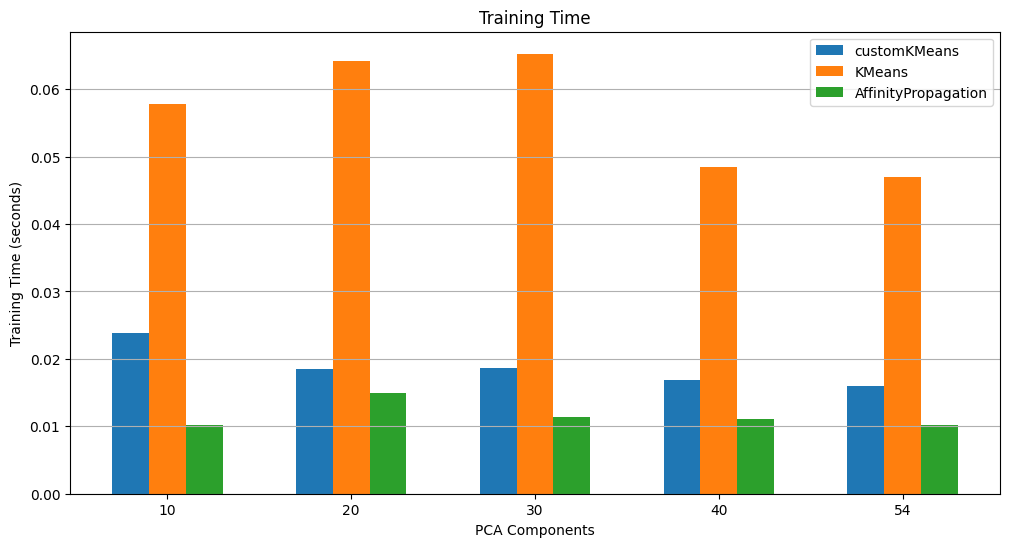

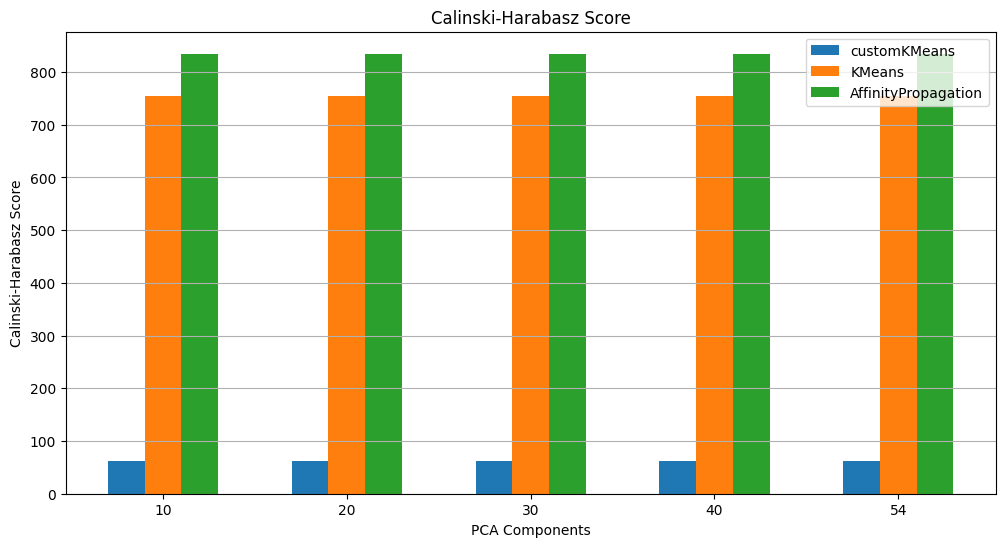

In [ ]:
models = ['customKMeans', 'KMeans', 'AffinityPropagation']
pcas_reductions = [10, 20, 30, 40, 54]
rand_scores = {model: [] for model in models}
training_times = {model: [] for model in models}
calinski_harabasz_scores = {model: [] for model in models}
silhouette_scores = {model: [] for model in models}

model_init = {
    'customKMeans': lambda: CustomKMeans(n_clusters=7, **best_customKMeans_params),
    'KMeans': lambda: KMeans(n_clusters=7, **best_kmeans_params),
    'AffinityPropagation': lambda: AffinityPropagation(**best_affinity_params)
}

for i in pcas_reductions:
    pca = PCA(n_components=i).fit_transform(labels_free) if i != 0 else labels_free
    for model in models:
        start_time = datetime.now()
        model_instance = model_init[model]().fit(pca)
        training_time = (datetime.now() - start_time).total_seconds()
        labels = model_instance.predict(pca)
        rand_score_val = rand_score(numbers, labels)
        calinski_harabasz_score_val = calinski_harabasz_score(pca, labels)
        silhouette_score_val = silhouette_score(pca, labels)  # Calculate Silhouette Score
        rand_scores[model].append(rand_score_val)
        training_times[model].append(training_time)
        calinski_harabasz_scores[model].append(calinski_harabasz_score_val)
        silhouette_scores[model].append(silhouette_score_val)  # Store Silhouette Score

plt.figure(figsize=(12, 6))
bar_width = 0.2
x = np.arange(len(pcas_reductions))

for idx, model in enumerate(models):
    plt.bar(x + idx * bar_width, rand_scores[model], width=bar_width, label=model)

plt.xlabel('PCA Components')
plt.ylabel('Rand Score')
plt.title('Rand Score vs PCA Components')
plt.xticks(x + bar_width, pcas_reductions)
plt.legend()
plt.grid(True, axis='y')
plt.show()

plt.figure(figsize=(12, 6))
for idx, model in enumerate(models):
    plt.bar(x + idx * bar_width, training_times[model], width=bar_width, label=model)

plt.xlabel('PCA Components')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time')
plt.xticks(x + bar_width, pcas_reductions)
plt.legend()
plt.grid(True, axis='y')
plt.show()

plt.figure(figsize=(12, 6))
for idx, model in enumerate(models):
    plt.bar(x + idx * bar_width, calinski_harabasz_scores[model], width=bar_width, label=model)

plt.xlabel('PCA Components')
plt.ylabel('Calinski-Harabasz Score')
plt.title('Calinski-Harabasz Score')
plt.xticks(x + bar_width, pcas_reductions)
plt.legend()
plt.grid(True, axis='y')
plt.show()

plt.figure(figsize=(12, 6))
for idx, model in enumerate(models):
    plt.bar(x + idx * bar_width, silhouette_scores[model], width=bar_width, label=model)

plt.xlabel('PCA Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs PCA Components')
plt.xticks(x + bar_width, pcas_reductions)
plt.legend()
plt.grid(True, axis='y')
plt.show()

### Итоги

В ходе работы были использованы и сравнены такие алгоритмы кластеризации как KMeans, Affinity Propogation, а также собственная реализация KMeans. Датасет содержал данные о различных городах во Франции.

Используя PCA, была сокращена размерность.

Лучше всего себя показала модель Affinity Propagation, а хуже всего KMeans. При этом Affinity Propagation оказалось на втором месте по скорости обучения. Медленнее всего обучалась модель KMeans. 